<a href="https://colab.research.google.com/github/ShivaniGawande/DLFinalProject_Fall22/blob/main/BERT_on_mergedData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np 
import pandas as pd
import seaborn as sns
import gensim
import re, string, unicodedata
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU, SpatialDropout1D
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.preprocessing.text import Tokenizer
!pip install tokenizers
!pip install transformers
from tokenizers import BertWordPieceTokenizer
import torch
import transformers
from transformers import TFBertModel


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 18.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 30.8 MB/s 
     |████████████████████████████████| 182 kB 61.9 MB/s 


In [ ]:
#loading data from google drive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


train_file_id = '1gfU_3JLesTYMDve8C6dMks9__dv5JT-5'
#test_file_id = '1J4K-z82tEr4jkwG1Hl1t-eigpcivqt3k' 

download = drive.CreateFile({'id': train_file_id})
download.GetContentFile('train.csv')
df  = pd.read_csv("train.csv")
df.head()
'''
url = "https://raw.githubusercontent.com/EducationalTestingService/sarcasm/master/twitter/sarcasm_detection_shared_task_twitter_training.jsonl"
url2 ='https://raw.githubusercontent.com/wjq-learning/MSTI/main/datasets/Textual%20target%20labels/train'
df = pd.read_json(url, lines=True)
'''
print(df.head())
     

   Unnamed: 0  is_sarcastic                                           headline
0       20062             0   what your brain actually does when you multitask
1        9968             0  'the daily show' puts trump supporters through...
2        3720             0  @USER people are walking around like zombies ,...
3       14183             0  women rewrite the constitution in jay-z's 'fam...
4        3731             1  unpublished twain autobiography rails against ...


In [ ]:
df.isna().sum() # Checking for NaN values

Unnamed: 0      0
is_sarcastic    0
headline        0
dtype: int64

In [ ]:
df.head()
df.rename(columns={'is_sarcastic': 'label'}, inplace=True)

In [ ]:
df.head()

,Unnamed: 0,label,headline
0,20062,0,what your brain actually does when you multitask
1,9968,0,'the daily show' puts trump supporters through...
2,3720,0,"@USER people are walking around like zombies ,..."
3,14183,0,women rewrite the constitution in jay-z's 'fam...
4,3731,1,unpublished twain autobiography rails against ...


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


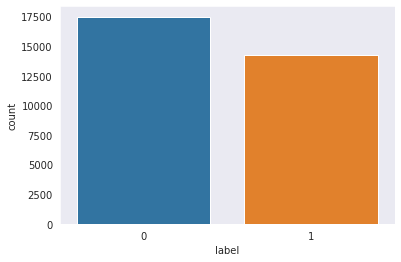

In [ ]:
sns.set_style("dark")
sns.countplot(df.label)

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [ ]:
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.headline)

corpus[:3]

['brain', 'actually', 'multitask']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'trump': 2349,
 'like': 2335,
 'people': 2266,
 'new': 2079,
 'one': 2049,
 'get': 1667,
 'man': 1584,
 'know': 1557,
 'would': 1433,
 'time': 1306}

In [ ]:
X= df.headline
y = df.label
y

0        0
1        0
2        0
3        0
4        1
        ..
31704    0
31705    0
31706    0
31707    1
31708    1
Name: label, Length: 31709, dtype: int64

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0 , stratify = y)

In [ ]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [ ]:
def encoder(sentences):
  ids = []
  for sentence in sentences:
    encoding = tokenizer.encode_plus(
    sentence,
    max_length=16,
    truncation = True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=False)
    ids.append(encoding['input_ids'])
  return ids


In [ ]:
train_ids = encoder(X_train.values)
test_ids = encoder(X_test.values)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
train_ids = tf.convert_to_tensor(train_ids)
test_ids = tf.convert_to_tensor(test_ids)
test_labels = tf.convert_to_tensor(y_test)
train_labels = tf.convert_to_tensor(y_train)

In [ ]:
bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")  
embedding = bert_encoder([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)   
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)    

model = tf.keras.Model(inputs=[input_word_ids], outputs=output) 

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 16)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             16, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [ ]:
num_epochs = 20
history = model.fit(x = train_ids, y = train_labels, epochs = num_epochs, verbose = 1, batch_size = 32, validation_data = (test_ids, test_labels))

Epoch 1/20


744/744 [==============================] - 129s 149ms/step - loss: 0.5225 - accuracy: 0.7335 - val_loss: 0.4290 - val_accuracy: 0.7982
Epoch 2/20
744/744 [==============================] - 110s 147ms/step - loss: 0.3780 - accuracy: 0.8308 - val_loss: 0.3958 - val_accuracy: 0.8165
Epoch 3/20
744/744 [==============================] - 111s 150ms/step - loss: 0.2747 - accuracy: 0.8844 - val_loss: 0.4385 - val_accuracy: 0.8216
Epoch 4/20
744/744 [==============================] - 111s 149ms/step - loss: 0.1851 - accuracy: 0.9260 - val_loss: 0.4867 - val_accuracy: 0.8269
Epoch 5/20
744/744 [==============================] - 111s 149ms/step - loss: 0.1114 - accuracy: 0.9574 - val_loss: 0.6076 - val_accuracy: 0.8238
Epoch 6/20
744/744 [==============================] - 110s 148ms/step - loss: 0.0733 - accuracy: 0.9728 - val_loss: 0.6268 - val_accuracy: 0.8221
Epoch 7/20
744/744 [==============================] - 110s 148ms/step - loss: 0.0519 - accuracy: 0.9814 - val_loss: 0.7643 - val_accura

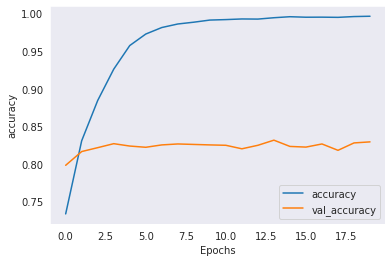

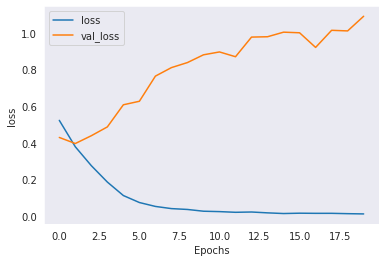

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(test_ids,test_labels)[1]*100 , "%")

248/248 [==============================] - 13s 51ms/step - loss: 1.0916 - accuracy: 0.8293
Accuracy of the model on Testing Data is -  82.93390274047852 %


In [ ]:
pred = model.predict(test_ids)
pred = np.round(pred).astype(int)
pred[:5]

248/248 [==============================] - 16s 51ms/step


array([[1],
       [1],
       [1],
       [1],
       [0]])

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4372
           1       0.79      0.84      0.82      3556

    accuracy                           0.83      7928
   macro avg       0.83      0.83      0.83      7928
weighted avg       0.83      0.83      0.83      7928



In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[3584,  788],
       [ 565, 2991]])

Text(69.0, 0.5, 'Actual')

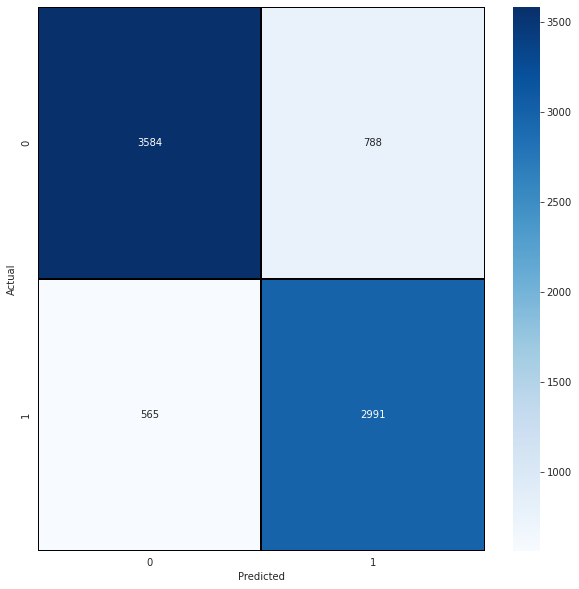

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")